In [1]:
# Import numpy library for numerical operations
import numpy as np
# Import torch library for building and training neural networks
import torch
# Import nn module from torch for building neural network layers
from torch import nn
# Import torch multiprocessing module for parallel processing
import torch.multiprocessing
# Import datasets and transforms modules from torchvision for loading and transforming image datasets
from torchvision import datasets, transforms
# Import SummaryWriter module from torch.utils.tensorboard for logging to TensorBoard
from torch.utils.tensorboard import SummaryWriter
# Import summary function from torchsummary for displaying model summary
from torchsummary import summary
# Import torchvision library for image processing
import torchvision
# Import pyplot module from matplotlib for plotting graphs
import matplotlib.pyplot as plt
# Import tqdm module for displaying progress bars
from tqdm.auto import tqdm
# Import default_timer function from timeit for measuring time taken for model training
from timeit import default_timer as timer

# Added
from torch.optim.lr_scheduler import StepLR

writer_path = 'runs/log_file_tensorboard'
# writer to log to tensorboard
writer = SummaryWriter(writer_path)

In [2]:
NUM_WORKERS = 4 # number of worker used when loading data into dataloader
DATASET_PATH = './spectrogramData' # path of our spectrogram dataset
IMAGE_SIZE = (775, 308) # image size
CHANNEL_COUNT = 3 # 3 channel as an image has 3 color (R,G,B)
ATTRIBUTION = ["acoustic", "bass", "electric", "lead", "pad"] # class labels exemple, we'll have 3 class in this exemple
ACCURACY_THRESHOLD = 90 # accuracy at which to stop

In [3]:
transform=transforms.ToTensor()

# Load the dataset
print(f"Loading images from dataset at {DATASET_PATH}")
dataset = datasets.ImageFolder(DATASET_PATH, transform=transform)

# train / test split
val_ratio = 0.2
val_size = int(val_ratio * len(dataset))
train_size = len(dataset) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
print(f"{train_size} images for training, {val_size} images for validation")

Loading images from dataset at ./spectrogramData
561 images for training, 140 images for validation


In [4]:
"""
Display a spectrogram image
@param img: Spectrogram of sound
@param one_channel: Whenever image is grey or has color (RGB) 
"""
def image_display_spectrogram(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
Display all the spectrogram of sounds within a batch
@param batches: Batch of data from a dataloader 
"""
def batches_display(batches, writer_path):
    dataiter = iter(batches)
    images, _ = next(dataiter)
    # create grid of images
    img_grid = torchvision.utils.make_grid(images)
    # show images
    image_display_spectrogram(img_grid, one_channel=False)
    # write to tensorboard
    writer.add_image(writer_path, img_grid)

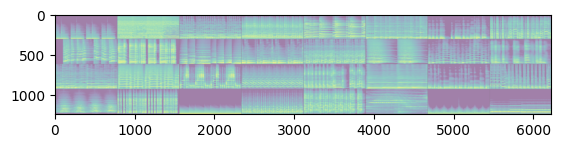

In [5]:
batch_size = 16

# Load training dataset into batches
train_batches = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)
# Load validation dataset into batches
val_batches = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size*2,
                                         num_workers=NUM_WORKERS)

# display 32 (batch_size*2) sample from the first validation batch
batches_display(val_batches, writer_path=writer_path)

In [6]:
# Define a neural network class that inherits from PyTorch nn.Module.
class neuralNetworkV1(nn.Module):
    # The __init__ method is used to declare the layers that will be used in the forward pass.
    def __init__(self):
        super().__init__() # required because our class inherit from nn.Module
        # First convolutional layer with 3 input channels for RGB images, 16 outputs (filters).
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
        # Second convolutional layer with 16 input channels to capture features from the previous layer, 16 outputs (filters).
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        # Third and fourth convolutional layers with 16 and 10 output channels respectively.
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(10, 10, kernel_size=3, stride=2, padding=1)
        # Max pooling layer to reduce feature complexity.
        self.pooling = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # ReLU activation function for introducing non-linearity.
        self.relu = nn.ReLU()
        # Flatten the 2D output from the convolutional layers for the fully connected layer.
        self.flatten = nn.Flatten()
        # Fully connected layer connecting to 1D neurons, with 3 output features for 3 classes.
        self.linear = nn.LazyLinear(out_features=5)
    
    # define how each data sample will propagate in each layer of the network
    def forward(self, x: torch.Tensor):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pooling(x)
        x = self.relu(self.conv3(x))
        x = self.pooling(x)
        x = self.relu(self.conv4(x))
        x = self.flatten(x)
        try:
            x = self.linear(x)
        except Exception as e:
            print(f"Error : Linear block should take support shape of {x.shape} for in_features.")
        return x

our_model = neuralNetworkV1()
our_model = our_model.to('cuda')

print("Model summary : ")
print(summary(our_model, (CHANNEL_COUNT, IMAGE_SIZE[0], IMAGE_SIZE[1])))

c:\Users\jyepi\OneDrive\Desktop\FastAICourse\testProject\testProjectEnv\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Model summary : 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 388, 154]             448
              ReLU-2         [-1, 16, 388, 154]               0
            Conv2d-3          [-1, 16, 194, 77]           2,320
              ReLU-4          [-1, 16, 194, 77]               0
         MaxPool2d-5           [-1, 16, 97, 38]               0
            Conv2d-6           [-1, 10, 49, 19]           1,450
              ReLU-7           [-1, 10, 49, 19]               0
         MaxPool2d-8            [-1, 10, 24, 9]               0
            Conv2d-9            [-1, 10, 12, 5]             910
             ReLU-10            [-1, 10, 12, 5]               0
          Flatten-11                  [-1, 600]               0
           Linear-12                    [-1, 5]           3,005
Total params: 8,133
Trainable params: 8,133
Non-trainable params: 0
------------------

In [7]:
# display total time training
def display_training_time(start, end):
    total_time = end - start
    print(f"Training time : {total_time:.3f} seconds")
    return total_time

# Display training infos for each epochs
def display_training_infos(epoch, val_loss, train_loss, accuracy):
    val_loss = round(val_loss.item(), 2)
    train_loss = round(train_loss.item(), 2)
    accuracy = round(accuracy, 2)
    print(f"Epoch : {epoch}, Training loss : {train_loss}, Validation loss : {val_loss}, Accuracy : {accuracy} %")

In [8]:
# Calculates accuracy between truth labels and predictions.
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# The core function for training the CNN
def train_neural_net(epochs, model, loss_func, optimizer, train_batches, val_batches):
    final_accuracy = 0
    for epoch in tqdm(range(epochs)):
        # training mode
        model.train()
        with torch.enable_grad():
            train_loss = 0
            for images, labels in train_batches:
                
                 # Move inputs and labels to GPU, added
                images, labels = images.to('cuda'), labels.to('cuda')
                
                predictions = model(images)
                loss = loss_func(predictions, labels)
                train_loss += loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss /= len(train_batches)
            writer.add_scalar("training loss", train_loss, epoch)
        # evaluation mode
        val_loss, val_accuracy = 0, 0
        model.eval()
        with torch.inference_mode():
            for images, labels in val_batches:

                # Move inputs and labels to GPU, added
                images, labels = images.to('cuda'), labels.to('cuda')

                predictions = model(images)
                val_loss += loss_func(predictions, labels)
                val_accuracy += accuracy_fn(y_true=labels, y_pred=predictions.argmax(dim=1))
            val_loss /= len(val_batches)
            val_accuracy /= len(val_batches)
            writer.add_scalar("validation loss", val_loss, epoch)
            final_accuracy = val_accuracy
        display_training_infos(epoch+1, val_loss, train_loss, val_accuracy)
        writer.add_scalar("accuracy", val_accuracy, epoch)
        if val_accuracy >= ACCURACY_THRESHOLD:
            break
    return final_accuracy

In [9]:
MAX_EPOCHS = 100
LEARNING_RATE = 0.01
GRADIENT_MOMENTUM = 0.90
loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(our_model.parameters(), lr=LEARNING_RATE, momentum=GRADIENT_MOMENTUM)

In [10]:
train_time_start_on_gpu = timer()
model_accuracy = train_neural_net(MAX_EPOCHS, our_model, loss_func, optimizer, train_batches, val_batches)
print(f"Training complete : {model_accuracy} %")
display_training_time(start=train_time_start_on_gpu,
                  end=timer())

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 1, Training loss : 1.57, Validation loss : 1.53, Accuracy : 30.21 %
Epoch : 2, Training loss : 1.54, Validation loss : 1.47, Accuracy : 30.21 %
Epoch : 3, Training loss : 1.5, Validation loss : 1.51, Accuracy : 31.46 %
Epoch : 4, Training loss : 1.39, Validation loss : 1.28, Accuracy : 44.58 %
Epoch : 5, Training loss : 1.25, Validation loss : 1.03, Accuracy : 61.88 %
Epoch : 6, Training loss : 1.03, Validation loss : 0.92, Accuracy : 70.42 %
Epoch : 7, Training loss : 0.93, Validation loss : 2.38, Accuracy : 31.25 %
Epoch : 8, Training loss : 1.23, Validation loss : 1.16, Accuracy : 51.25 %
Epoch : 9, Training loss : 1.06, Validation loss : 0.94, Accuracy : 65.42 %
Epoch : 10, Training loss : 0.91, Validation loss : 0.94, Accuracy : 68.12 %
Epoch : 11, Training loss : 0.87, Validation loss : 0.99, Accuracy : 66.88 %
Epoch : 12, Training loss : 0.79, Validation loss : 1.16, Accuracy : 61.25 %
Epoch : 13, Training loss : 0.89, Validation loss : 1.01, Accuracy : 71.04 %
Epoch : 1

In [ ]:
torch.save(our_model, "./")
writer.flush()
writer.close()